In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Sequential
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST, CIFAR10, GTSRB
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [ ]:
import PIL

In [ ]:
class Clip(nn.Module):
    def __init__(self):
        super(Clip, self).__init__()

    def forward(self, x: torch.tensor):
        return torch.where(x > 1.0, 1.0, x)

In [ ]:
class OcclusionFirstLayer(nn.Module):
    def __init__(self, size_in, size_out): #, color_in):
        super().__init__()
        self.size_in = size_in
        # self.color_in = color_in
        self.size_out = size_out
        weights, bias = self.init_weights_bias(size_in, size_out)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, corner, box):
        input = torch.tensor([corner[0], box[0], corner[1], box[1]]).type(torch.FloatTensor)
        # print(type(self.weights), type(self.bias))
        return torch.matmul(self.weights, input) + self.bias

    def init_weights_bias(self, size_in, size_out):
        weights = torch.zeros(size_out, size_in)   # in uniform case out = 2(m+n), in = 4
        bias = torch.zeros(size_out)

        # set the weight
        block_size = (size_out) // 4   # out_size = 2(m+n), in uniform case colour = 0 => block_size = 2(m+n) // 4 usually m = n
        for i in range(4):
            if i == 0 or i == 2:
                for j in range(block_size):
                    weights[i * block_size + j, i] = 1
                    bias[i * block_size + j] = -(j + 1)
            elif i == 1 or i == 3:
                for j in range(block_size):
                    weights[i * block_size + j, i - 1] = -1
                    weights[i * block_size + j, i] = -1
                    bias[i * block_size + j] = j + 2

        # for c in range(self.color_in):
        #     weights[-1 - c, -1 - c] = 1
        # print(weights, bias)
        return weights, bias


In [ ]:
class OcclusionSecondLayer(nn.Module):
    def __init__(self, size_in, size_out): #, color_in):
        super().__init__()
        self.size_in = size_in
        self.size_out = size_out
        # self.color_in = color_in
        weights, bias = self.init_weights_bias(size_in, size_out)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        return torch.matmul(self.weights, x) + self.bias

    def init_weights_bias(self, size_in, size_out):
        weights = torch.zeros(size_out, size_in)
        block_size = (size_out) // 2
        for i in range(2):
            for j in range(block_size):
                weights[i * block_size + j, 2 * i * block_size + j] = -1
                weights[i * block_size + j, 2 * i * block_size + block_size + j] = -1
        bias = torch.ones(size_out)
        # for c in range(self.color_in):
        #     weights[-1 - c, -1 - c] = 1
        #     bias[-1 - c] = 0
        # print(weights, bias)
        return weights, bias

In [ ]:
class OcclusionThirdLayer(nn.Module):
    def __init__(self, size_in, size_out, image_shape):
        super().__init__()
        self.size_in = size_in
        self.size_out = size_out
        self.image_shape = image_shape
        weights, bias = self.init_weights_bias(size_in, size_out, image_shape)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        return torch.matmul(self.weights, x) + self.bias
        # h3 = []
        # image_channel, image_height, image_width = image_shape
        # for i in range(image_width):
        #     h3_i = nn.functional.linear(x, self.weights[2 * i]) + nn.functional.linear(x, self.weights[2 * i + 1]) + self.bias[i]
        #     h3.append(nn.functional.relu(h3_i))

    def init_weights_bias(self, size_in, size_out, image_shape):
        weights = torch.zeros(size_out, size_in)
        bias = torch.zeros(size_out)
        image_channel, image_height, image_width = image_shape
        input_block_size = (size_in - image_channel) // 2
        # input_block_size = size_in // 2
        # block_size = size_out // (1 + image_channel)
        block_size = image_height
        # for i in range(1 + image_channel):
        #     for j in range(block_size):
        #         r, c = j // 2, j % 2
        #         weights[i * block_size + j, r] = 1
        #         weights[i * block_size + j, input_block_size + c] = 1
        #         if i >= 1:
        #             weights[i * block_size + j, -i] = 1

        for i in range(image_width):
            for j in range(block_size):
                weights[i * block_size + j, i] = 1
                weights[i * block_size + j, input_block_size + j] = 1


        # bias[0:block_size] = -torch.ones(block_size)
        # bias[block_size:] = -torch.ones(block_size * image_channel) * 2
        # print(weights, bias)
        bias = -torch.ones(size_out)

        # print(weights, bias)
        return weights, bias

In [ ]:
class OcclusionFourthLayer(nn.Module):
    def __init__(self, size_in, size_out, image, occlusion_colour, is_multiform, epsilon): #, model_first_layer, is_cnn):
        super().__init__()
        self.size_in = size_in
        self.occlusion_colour = occlusion_colour
        # if not is_cnn:
        #     self.size_out = model_first_layer.size_out
        # else:
        #     self.size_out = size_out
        self.image = image
        self.image_channel, self.image_height, self.image_width = image.shape
        weights, bias = self.init_weights_bias(size_in, size_out, image, occlusion_colour, is_multiform, epsilon)
        # if not is_cnn:
        #     weights = torch.matmul(model_first_layer.weights, weights)
        #     bias = model_first_layer.bias + torch.matmul(model_first_layer.weights, bias)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        # print(torch.matmul(self.weights, x))
        # plt.imshow(torch.abs(torch.relu(torch.reshape(torch.matmul(self.weights, x) + self.bias,(self.image_height, self.image_width)))),cmap='gray')
        return (torch.matmul(self.weights, x)) + self.bias
        # return torch.mul(self.weights, x) + self.bias

    def init_weights_bias(self, size_in, size_out, image, occlusion_colour, is_multiform, epsilon):
        # print(image)
        # assert image is a tensor
        assert isinstance(image, torch.Tensor)
        # flatten image into 1d
        image_flatten = image.view(-1)
        # print(image)
        image_channel, image_height, image_width = image.shape

        if is_multiform:
            # epsilons = epsilon*torch.ones(size_out) mXn
            epsilons = (epsilon - (-epsilon)) * torch.rand(size_out) + (-epsilon)

        weights = torch.zeros(size_out, size_in)
        # weights = torch.round(epsilons,decimals=4)

        for channel in range(image_channel):
            for i in range(size_out // image_channel):
                if not is_multiform:
                    weights[channel * image_height * image_width + i, i] = occlusion_colour[channel] - image_flatten[channel * image_height * image_width + i]
                else:
                    e = (epsilon - (-epsilon)) * torch.rand(1) + (-epsilon)
                    weights[channel * image_height * image_width + i, i] = torch.round(epsilons[channel * image_height * image_width + i],decimals=4)
        # print(torch.reshape(epsilons,(image_height, image_width)))
                # weights[channel * image_height * image_width + i, (channel + 1) * image_height * image_width + i - 2] = 1

        bias = image_flatten #torch.ones(size_out) * image_flatten

        # print(weights, bias)
        return weights, bias

In [ ]:
def forward(image, channels, width, height, corner, box, image_shape, occlusion_colour, is_multiform, epsilon):
    c,m,n = channels, width, height
    a,b = corner
    w,h = box
    # initialization
    first_layer = OcclusionFirstLayer(4, 2*(m+n))
    second_layer = OcclusionSecondLayer(2*(m+n), (m+n))
    third_layer = OcclusionThirdLayer((m+n), m*n, image_shape)
    fourth_layer = OcclusionFourthLayer(m*n, c*m*n, image, occlusion_colour, is_multiform, epsilon)

    first_out = torch.relu(first_layer((a,b), (w,h)))
    # print(first_out)
    second_out = torch.relu(second_layer(first_out))
    # print(second_out)
    third_out = torch.relu(third_layer(second_out))
    # print(third_out)
    activation = Clip()
    fourth_out = activation(torch.relu(fourth_layer(third_out)))
    # print(fourth_out)

    return first_out, second_out, third_out, fourth_out

In [ ]:
# mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#         ]))

mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor(),download=True)

cifar10 = CIFAR10(root = 'data/', train = True, transform = transforms.ToTensor(),download=True)

gtsrb = GTSRB(root = 'data/', split='train', transform = transforms.ToTensor(),download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 22.3MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 93.9MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.40MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 170M/170M [00:01<00:00, 91.3MB/s]


Extracting data/cifar-10-python.tar.gz to data/


100%|██████████| 187M/187M [00:10<00:00, 18.5MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


In [ ]:
gtsrb = GTSRB(root = 'data/', split='train', transform = transforms.Compose([
    transforms.Resize((32,32),transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
]),download=True)

In [ ]:
image_tensor, label = mnist_dataset[15001]
# image_tensor, label = cifar10[14747]
# image_tensor, label = gtsrb[3333]

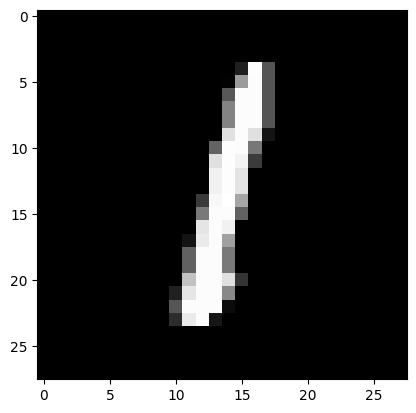

In [ ]:
plt.imshow(image_tensor[0],cmap = 'gray')
# plt.imshow(transforms.ToPILImage()(image_tensor))
# plt.imshow(np.transpose(image_tensor,(1,2,0)), interpolation='nearest')

In [ ]:
a = 4
b = 7
w = 6
h = 10
c = image_tensor.shape[0]
m = image_tensor.shape[1]
n = image_tensor.shape[2]
shape = image_tensor.shape

In [ ]:
occlusion_color = torch.rand(3)
r1, r2, r3, result = forward(image_tensor,c, m, n, (a,b), (w,h), shape, occlusion_color, True, 0.9)

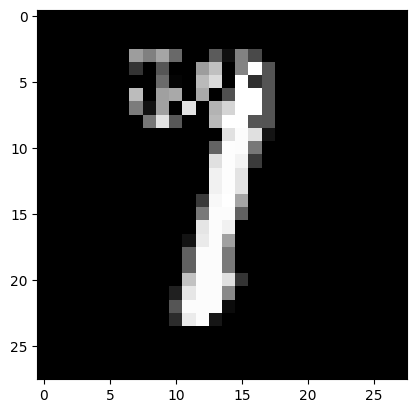

In [ ]:
result = torch.reshape(result,(c,m,n))
plt.imshow(result[0],cmap = 'gray')
# plt.imshow(transforms.ToPILImage()(result))

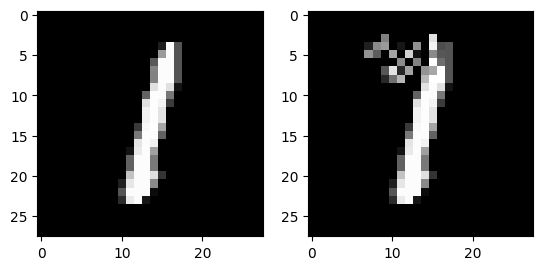

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_tensor[0],cmap='gray')
axarr[1].imshow(result[0],cmap='gray')
#
# axarr[0].imshow(transforms.ToPILImage()(image_tensor))
# axarr[1].imshow(transforms.ToPILImage()(result))

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# n_epochs = 3
# batch_size_train = 64
# batch_size_test = 1000
# learning_rate = 0.01
# momentum = 0.5
# log_interval = 10

# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('/files/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)

# network = Net()
# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)

# train_losses = []
# train_counter = []
# test_losses = []
# test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# def train(epoch):
#   network.train()
#   for batch_idx, (data, target) in enumerate(train_loader):
#     optimizer.zero_grad()
#     output = network(data)
#     loss = F.nll_loss(output, target)
#     loss.backward()
#     optimizer.step()
#     if batch_idx % log_interval == 0:
#     #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#         # epoch, batch_idx * len(data), len(train_loader.dataset),
#         # 100. * batch_idx / len(train_loader), loss.item()))
#       train_losses.append(loss.item())
#       train_counter.append(
#         (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#     #   torch.save(network.state_dict(), '/results/model.pth')
#     #   torch.save(optimizer.state_dict(), '/results/optimizer.pth')

# for epoch in range(1, n_epochs + 1):
#   train(epoch)

In [ ]:
# pred = network(result).data.max(1, keepdim=True)[1]
# pred

In [ ]:
# torchvision.utils.save_image(result,'gtsrb_uni1.png')

In [ ]:
# image_tensor, label = mnist_dataset[2222]
# image_tensor, label = cifar10[6152]
image_tensor, label = gtsrb[3563]

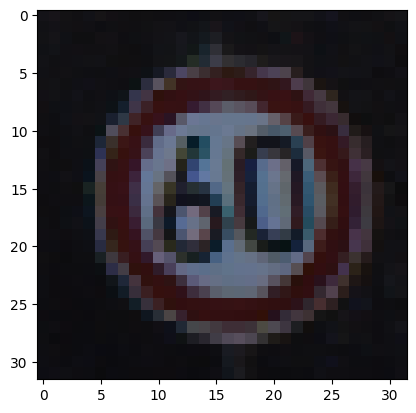

In [ ]:
# plt.imshow(image_tensor[0],cmap = 'gray')
plt.imshow(transforms.ToPILImage()(image_tensor))
# plt.imshow(np.transpose(image_tensor,(1,2,0)), interpolation='nearest')

In [ ]:
a = 22
b = 3
w = 6
h = 20
c = image_tensor.shape[0]
m = image_tensor.shape[1]
n = image_tensor.shape[2]
shape = image_tensor.shape

In [ ]:
occlusion_color = torch.rand(3)
r1, r2, r3, result = forward(image_tensor,c, m, n, (a,b), (w,h), shape, occlusion_color, True, 0.3)

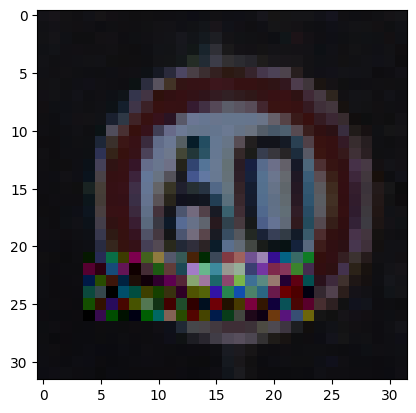

In [ ]:
result = torch.reshape(result,(c,m,n))
# plt.imshow(result[0],cmap = 'gray')
plt.imshow(transforms.ToPILImage()(result))

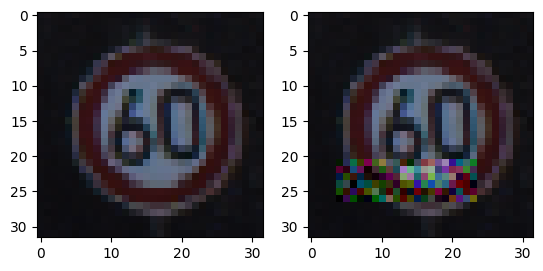

In [ ]:
f, axarr = plt.subplots(1,2)
# axarr[0].imshow(image_tensor[0],cmap='gray')
# axarr[1].imshow(result[0],cmap='gray')
#
axarr[0].imshow(transforms.ToPILImage()(image_tensor))
axarr[1].imshow(transforms.ToPILImage()(result))

In [ ]:
# from torch.utils.data.sampler import SubsetRandomSampler
# from torchvision import datasets
# import torchvision.transforms as transforms
# from torch.utils.data.sampler import SubsetRandomSampler

# import torch.nn as nn
# import torch.nn.functional as F

# import torch.optim as optim
# # Check if CUDA is available
# train_on_gpu = torch.cuda.is_available()

# if train_on_gpu:
#     print("CUDA is available! Training on GPU...")
# else:
#     print("CUDA is not available. Training on CPU...")

# # Number of subprocesses to use for data loading
# num_workers = 0

# # How many samples per batch to load
# batch_size = 20

# # Percentage of training set to use as validation
# n_valid = 0.2

# # Convert data to a normalized torch.FloatTensor
# # Data augmentation
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), # randomly flip and rotate
#     transforms.RandomRotation(10),
#                                 transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                ])

# # Select training_set and testing_set
# train_data = datasets.CIFAR10("data",
#                               train= True,
#                              download=True,
#                              transform = transform)

# test_data = datasets.CIFAR10("data",
#                               train= False,
#                              download=True,
#                              transform = transform)

# # Get indices for training_set and validation_set
# n_train = len(train_data)
# indices = list(range(n_train))
# np.random.shuffle(indices)
# split = int(np.floor(n_valid * n_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # Define samplers for obtaining training and validation
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# # Prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size = batch_size,
#                                           sampler = train_sampler,
#                                           num_workers = num_workers)

# valid_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size = batch_size,
#                                           sampler = valid_sampler,
#                                           num_workers = num_workers)

# test_loader = torch.utils.data.DataLoader(test_data,
#                                            batch_size = batch_size,
#                                           num_workers = num_workers)

# # Specify the image classes
# classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
#           "horse", "ship", "truck"]

# class CNNNet(nn.Module):
#     def __init__(self):
#         super(CNNNet, self).__init__()

#         # Convolutional layers
#                             #Init_channels, channels, kernel_size, padding)
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

#         # Pooling layers
#         self.pool = nn.MaxPool2d(2,2)

#         # FC layers
#         # Linear layer (64x4x4 -> 500)
#         self.fc1 = nn.Linear(64 * 4 * 4, 500)

#         # Linear Layer (500 -> 10)
#         self.fc2 = nn.Linear(500, 10)

#         # Dropout layer
#         self.dropout = nn.Dropout(0.25)

#     def forward(self, x):
#         x = self.pool(F.elu(self.conv1(x)))
#         x = self.pool(F.elu(self.conv2(x)))
#         x = self.pool(F.elu(self.conv3(x)))

#         # Flatten the image
#         x = x.view(-1, 64*4*4)
#         x = self.dropout(x)
#         x = F.elu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# model = CNNNet()
# print(model)

# # Move tensors to GPU is CUDA is available
# if train_on_gpu:
#     model.cuda()

# # Specify the Loss function
# criterion = nn.CrossEntropyLoss()

# # Specify the optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# # number of epochs to train the model
# n_epochs = 25 # you may increase this number to train a final model

# valid_loss_min = np.Inf # track change in validation loss

# for epoch in range(1, n_epochs+1):

#     # keep track of training and validation loss
#     train_loss = 0.0
#     valid_loss = 0.0

#     ###################
#     # train the model #
#     ###################
#     model.train()
#     for data, target in train_loader:
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the batch loss
#         loss = criterion(output, target)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update training loss
#         train_loss += loss.item()*data.size(0)

#     ######################
#     # validate the model #
#     ######################
#     model.eval()
#     for data, target in valid_loader:
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the batch loss
#         loss = criterion(output, target)
#         # update average validation loss
#         valid_loss += loss.item()*data.size(0)

#     # calculate average losses
#     train_loss = train_loss/len(train_loader.dataset)
#     valid_loss = valid_loss/len(valid_loader.dataset)

#     # print training/validation statistics
#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#         epoch, train_loss, valid_loss))

#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model.state_dict(), 'model_cifar.pt')
#         valid_loss_min = valid_loss

# model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# pred = model(result).data.max(1, keepdim=True)[1]
# classes[pred]

In [ ]:
plt.imshow(transforms.ToPILImage()(result[0] - image_tensor[0]))

In [ ]:
# plt.imshow(torch.reshape(r1,(112,1)),cmap = 'gray')

In [ ]:
# plt.imshow(torch.reshape(r2,(56,1)),cmap = 'gray')

In [ ]:
# plt.imshow(torch.reshape(r3,(m,n)),cmap = 'gray')

In [ ]:
# a_ = 1.5
# b_ = 2
# w_ = 1
# h_ = 1
# image = torch.tensor([[[0,0,0,0,0],
#                     [0,0,0.67,0.33,0],
#                        [0,0,0,0.78,0],
#                        [0,0,0,0.44,0],
#                        [0, 0, 0, 0.37, 0]]])
# m_ = image.shape[1]
# n_ = image.shape[2]
# shape_ = image.shape

In [ ]:
# new = (image[0])

In [ ]:
# plt.imshow(new,cmap='gray')

In [ ]:
# result_ = forward(image, 1,m_, n_, (a_,b_), (w_,h_), shape_, 0, True, 0.7)

In [ ]:
# plt.imshow(torch.reshape(result_[3],(m_,n_)),cmap='gray')

In [ ]:
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(image[0], cmap='gray')
# axarr[1].imshow(torch.reshape(result_[3],(m_,n_)), cmap='gray')

In [ ]:
# plt.imshow(torch.reshape(result_[2],(m_,n_)),cmap = 'gray')

In [ ]:
# image

In [ ]:
# torch.reshape(result_[3],(m_,n_))

In [ ]:
# sum((image[0].view(-1))-result_[3]!=0)

In [ ]:
# image.view(-1)